In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE,MDS
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score,roc_auc_score, accuracy_score
import warnings
from imblearn.over_sampling import SMOTE
from scipy import interp
import random
warnings.filterwarnings("ignore", category=FutureWarning)
random.seed(13072967)
np.random.seed(13072967)
# Filter out UserWarning messages
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
data = pd.read_csv('musicData.csv')
data = data.replace('?', np.nan)  # Replace '?' with NaN
data = data.drop_duplicates()
# Check for zero or negative values in the 'acousticness' column
if (data['acousticness'] <= 0).any():
    # Add a small positive constant to each value
    data['acousticness'] = data['acousticness'] + np.finfo(float).eps
# Apply a log transformation to the 'acousticness' column
data['acousticness'] = np.log(data['acousticness'])


Data Processing


In [22]:
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
data1=data[['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','valence','music_genre']]
data1['mode'].replace({'Major': 0, 'Minor': 1}, inplace=True)
label_encoder = LabelEncoder()
data1['key']=label_encoder.fit_transform(data1['key'])
data1['music_genre'] = label_encoder.fit_transform(data1['music_genre'])

In [23]:
data1['tempo'] = data1['tempo'].astype(float)
data1['key'] = data1['key'].astype(float)
data1.dropna(inplace=True)
y = data1['music_genre']
X=data1.drop(['music_genre'],axis=1)
genre_counts = data1['music_genre'].value_counts()
print(genre_counts)

9    4561
7    4521
6    4520
8    4504
3    4500
1    4497
0    4495
4    4486
2    4470
5    4466
Name: music_genre, dtype: int64


In [25]:
# Assuming the DataFrame containing the data is named 'data' and the column containing the genres is named 'music_genre'
data=data1
genres = data['music_genre'].unique()


X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series(dtype='object')
y_test = pd.Series(dtype='object')

# Assuming the target column is named 'target'
target_col = 'music_genre'

for genre in genres:
    genre_data = data[data['music_genre'] == genre]
    
    # If the genre has less than or equal to 500 samples, use all samples for the test set and none for the train set
    if genre_data.shape[0] <= 500:
        test_genre_data = genre_data
    else:
        _, test_genre_data = train_test_split(genre_data, test_size=500, random_state=13072967)
    
    train_genre_data = genre_data.drop(test_genre_data.index)
    
    X_train = pd.concat([X_train, train_genre_data.drop(target_col, axis=1)])
    X_test = pd.concat([X_test, test_genre_data.drop(target_col, axis=1)])
    y_train = y_train.append(train_genre_data[target_col])
    y_test = y_test.append(test_genre_data[target_col])

# Process numeric features
num_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11]  # columns with numeric data
X_train_num = X_train.iloc[:, num_features]  # select only numeric columns
X_test_num = X_test.iloc[:, num_features]  # select only numeric columns

X_train_num = stats.zscore(X_train_num)  # standardize numeric columns in X_train
X_test_num = stats.zscore(X_test_num)  # standardize numeric columns in X_test

# Update X_train and X_test with standardized numeric columns
X_train.iloc[:, num_features] = X_train_num
X_test.iloc[:, num_features] = X_test_num

# Reset index for y_train and y_test
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


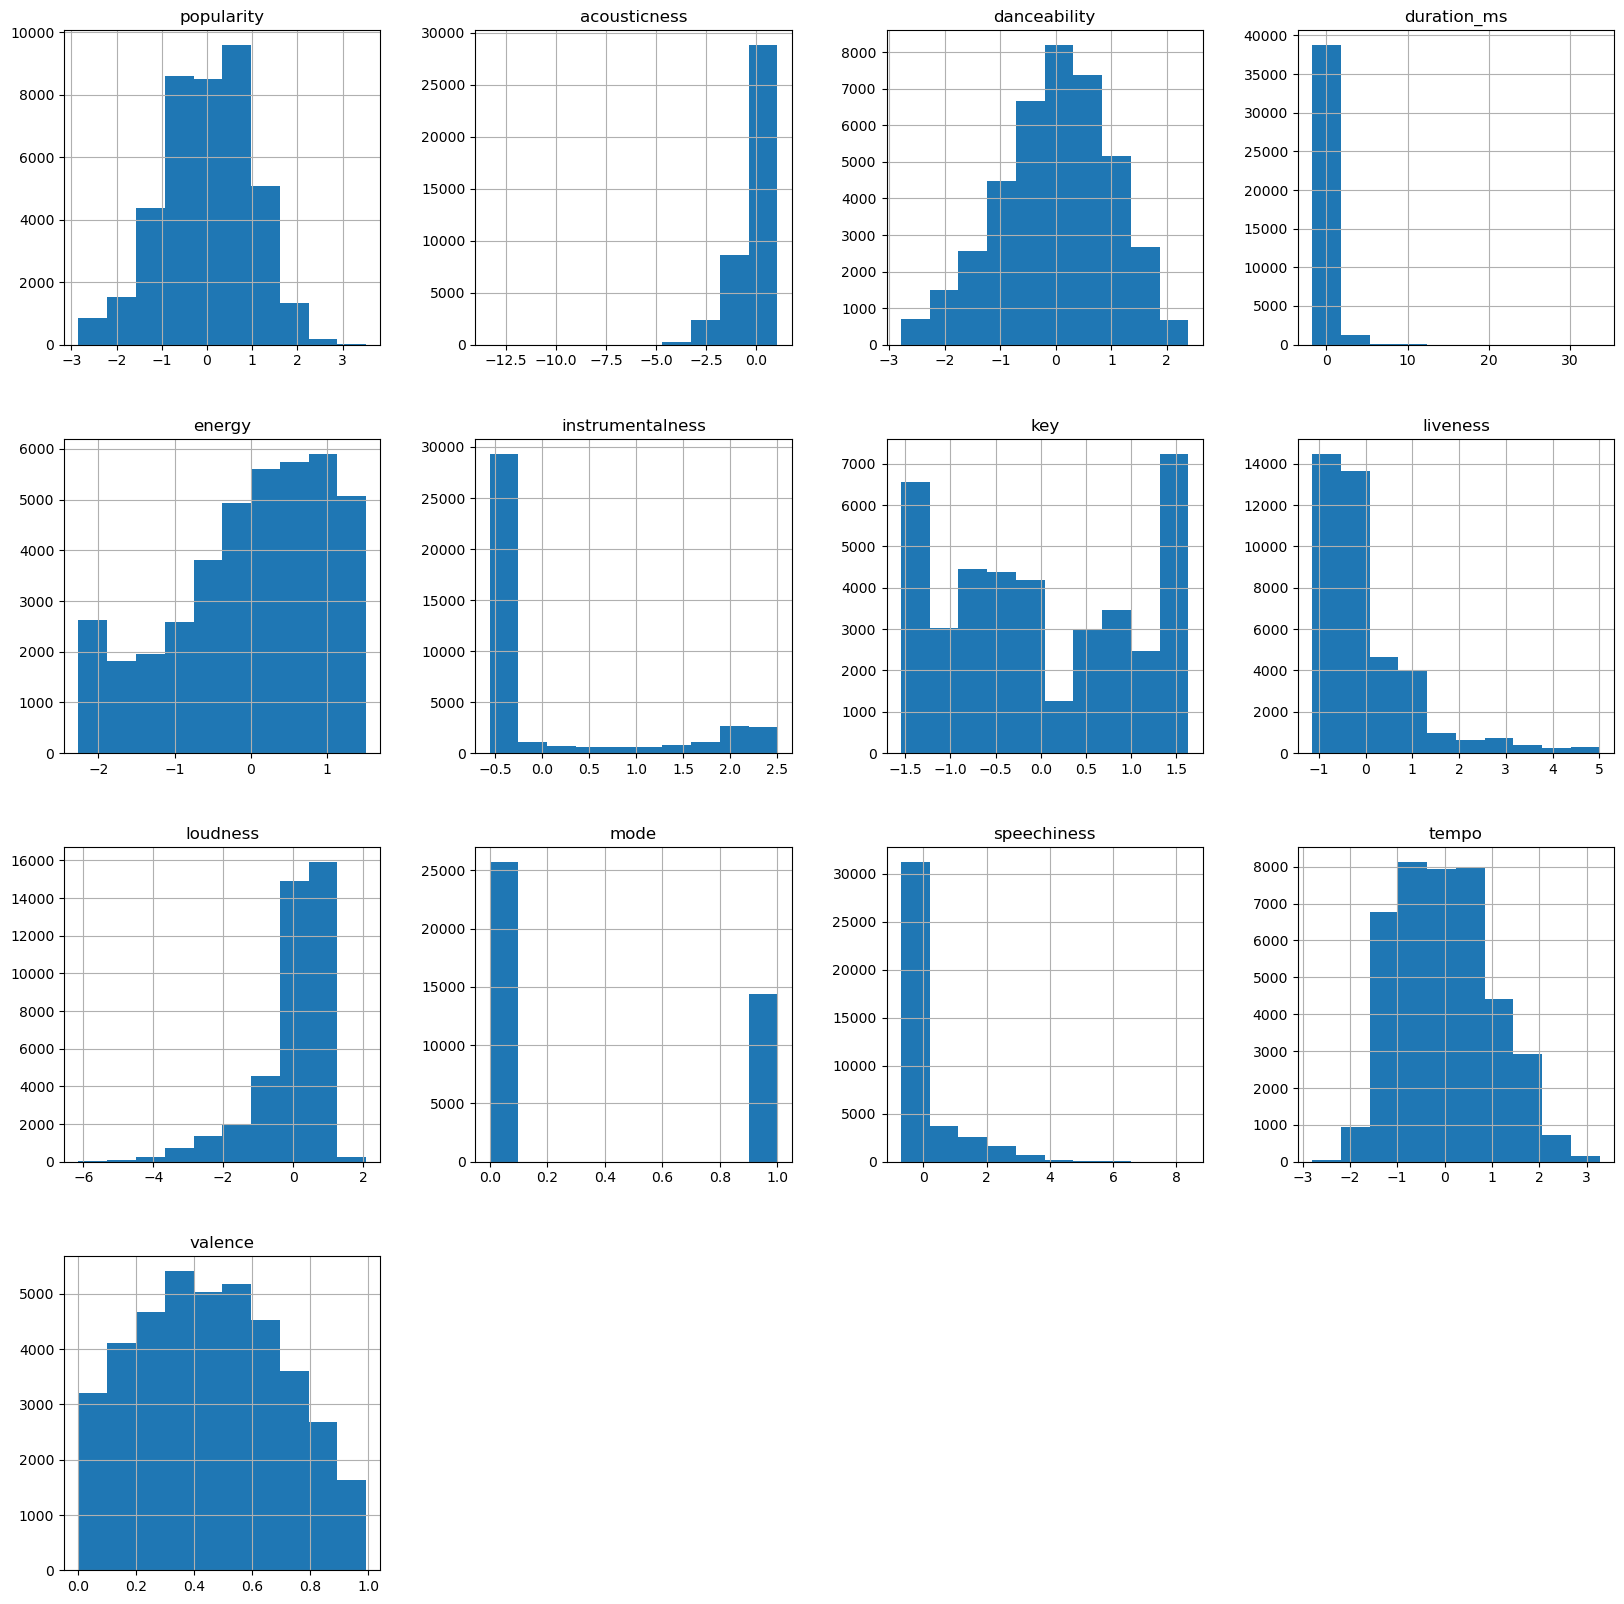

40020


In [6]:
X_train.hist(figsize=(20,20))
plt.show()
Xn=X_train
print(len(X_train))

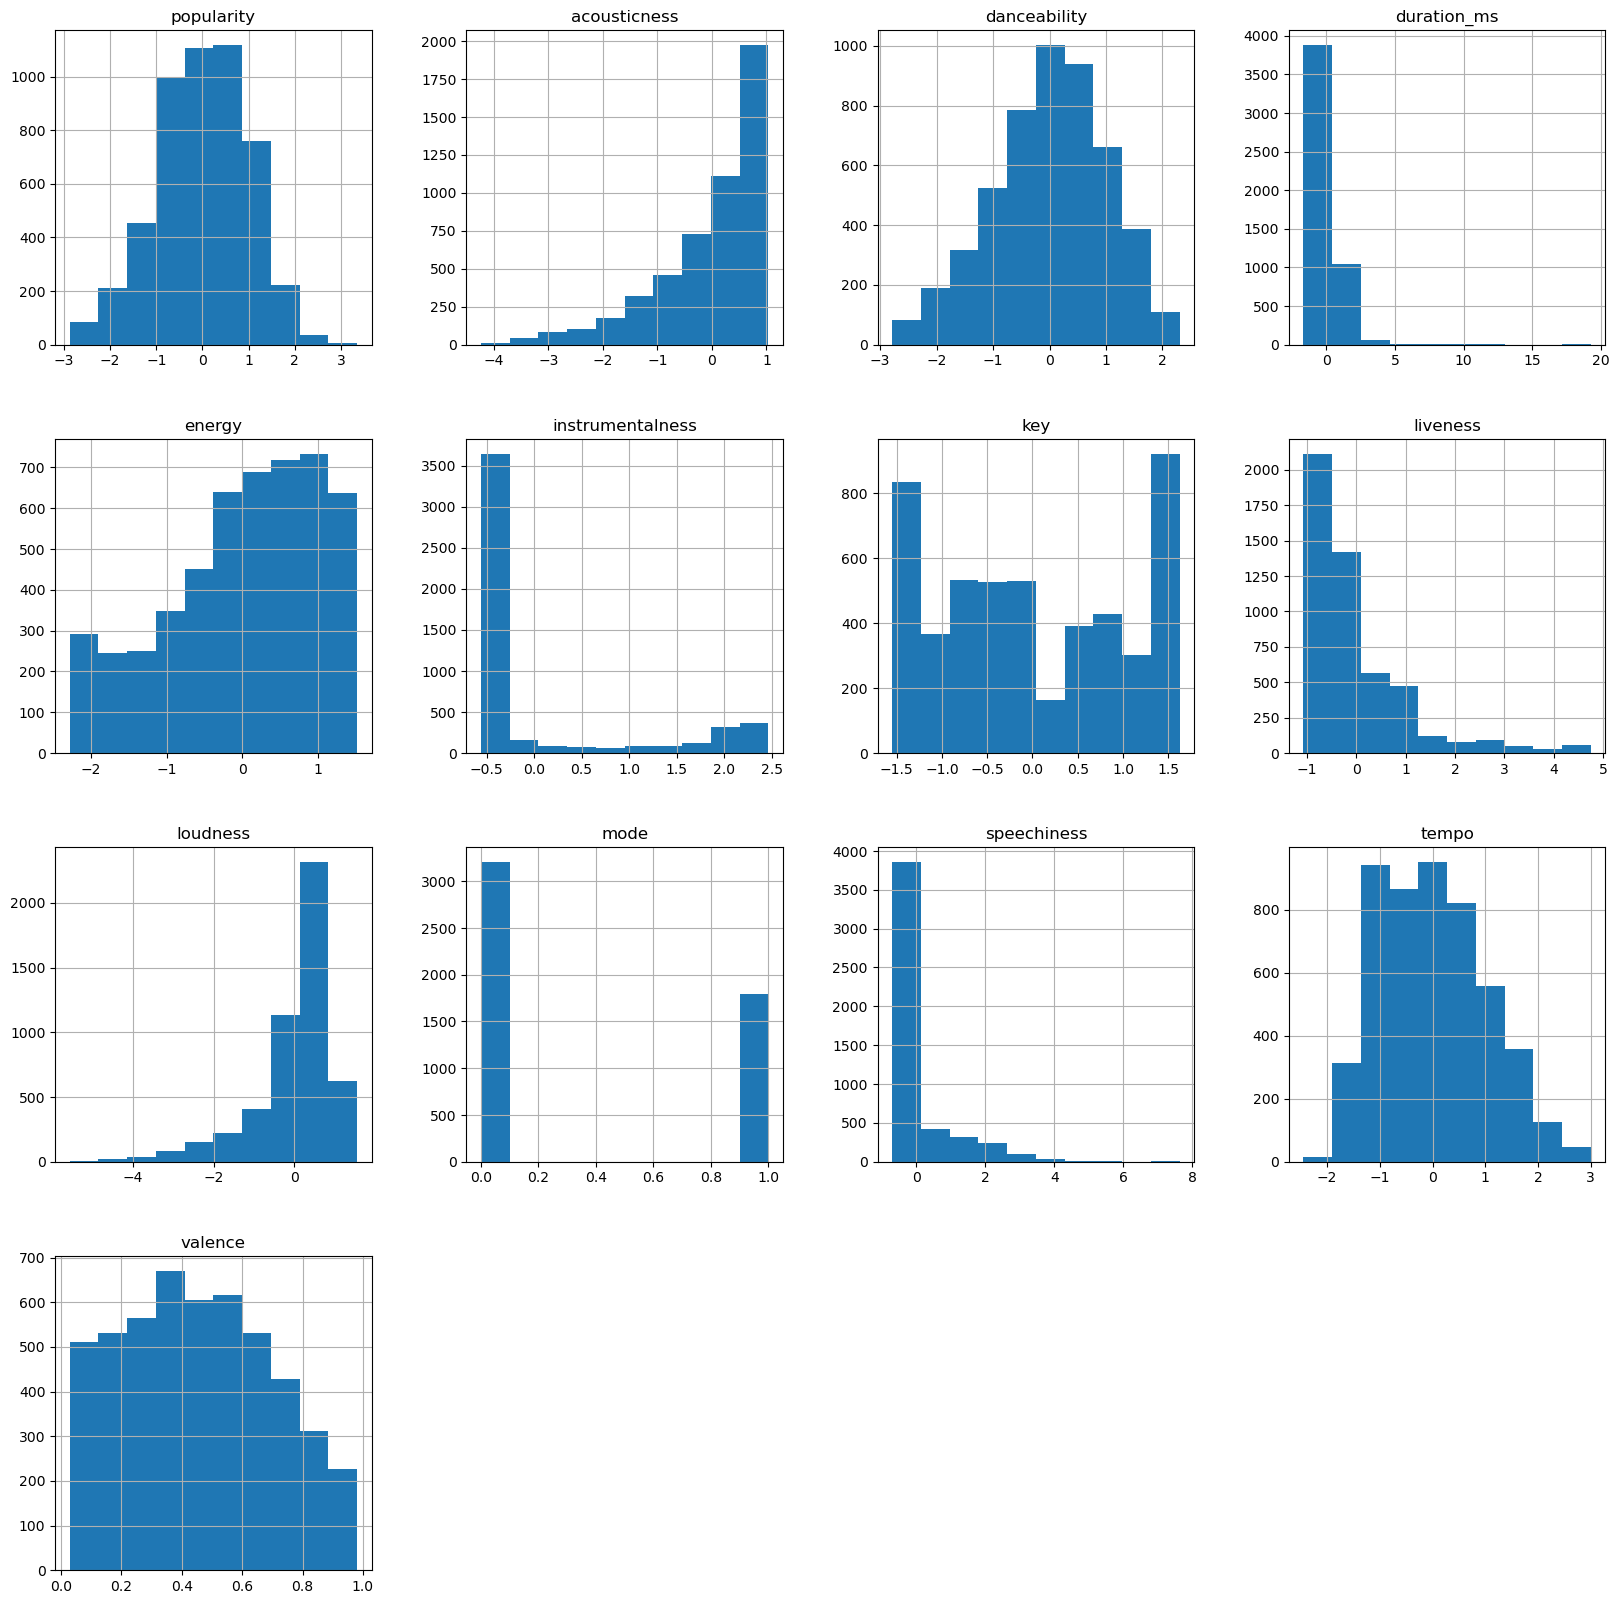

5000


In [27]:
X_test.hist(figsize=(20,20))
plt.show()
Xt=X_test
print(len(X_test))

In [28]:
# Binarize the test labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

In [29]:
model1=MLPClassifier(random_state=13072967)
model1.fit(X_train, y_train)
y_pred_proba =model1.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("Neural Network ROC AUC score:",roc_auc["micro"])
pred=model1.predict(X_test)
acc=(y_test == pred).sum() / len(y_test)
print(acc)

Neural Network ROC AUC score: 0.9332554888888891
0.5818


In [ ]:
model2=AdaBoostClassifier(random_state=13072967)
model2.fit(X_train, y_train)

y_pred_proba =model2.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("Adaboost ROC AUC score:",roc_auc["micro"])
pred=model2.predict(X_test)
acc=(y_test == pred).sum() / len(y_test)
print(acc)

Adaboost ROC AUC score: 0.8732190577777778
0.4892


In [ ]:
model3=RandomForestClassifier(random_state=13072967)
model3.fit(X_train, y_train)
# Binarize the test labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
y_pred_proba =model3.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("RandomForest ROC AUC score:",roc_auc["micro"])


pred=model3.predict(X_test)
acc=(y_test == pred).sum() / len(y_test)
print(acc)

RandomForest ROC AUC score: 0.9249857400000001
0.55


In [ ]:
svm = LinearSVC(random_state=13072067)
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("SVM ROC AUC score:",roc_auc["micro"])

pred=clf.predict(X_test)
acc=(y_test == pred).sum() / len(y_test)
print(acc)

SVM ROC AUC score: 0.8967231599999999
0.501


Dimensionality Reduction

0.27785397637199727
0.4076960321659304
0.499705306396085
0.5883119788756762
0.6736793606313713
0.7520349635428917
0.8213715934327631
0.8788541693265055
0.9318292007372578
0.9650801557909497
0.9848914911312799
0.9966090689125034


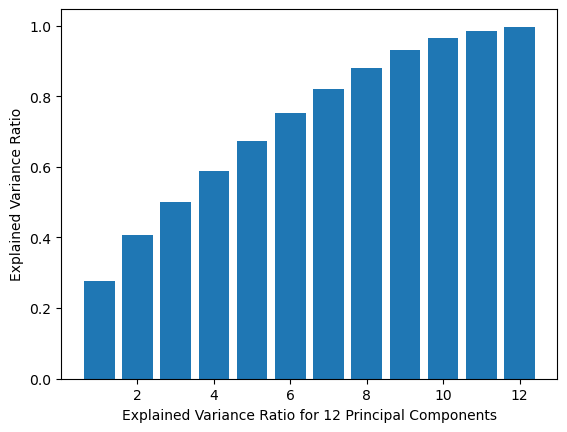

In [30]:
s=[]
for n in range(1, 13):
    # Fit PCA and transform data
    pca = PCA(n_components=n, random_state=13072967)
    pca.fit(X_train)
    P = pca.transform(X_train)
    s.append(sum(pca.explained_variance_ratio_))
    print(sum(pca.explained_variance_ratio_))
    # Plot explained variance ratio for each principal component
plt.bar(range(1, n+1), s)
plt.xlabel(f"Explained Variance Ratio for {n} Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.show()


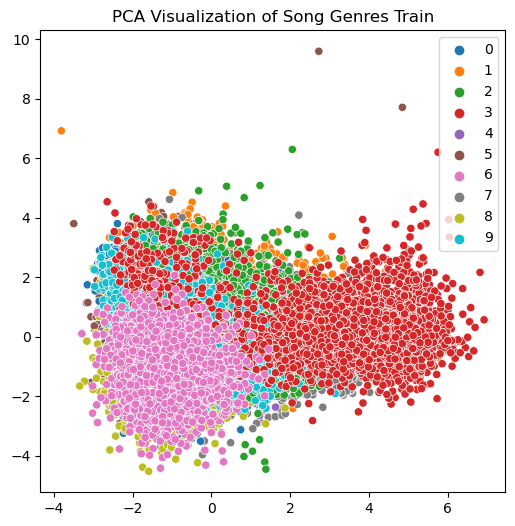

In [31]:
pca = PCA(n_components=2, random_state=13072967)
pca.fit(X_train)
X_pca= pca.transform(X_train)
# Define a color map with a distinct color for each label
cmap = plt.get_cmap('tab10')

# Get a list of all the unique labels in the training set
labels = np.unique(y_train)

# Define a dictionary that maps each label to a distinct color
palette = {label: cmap(i) for i, label in enumerate(labels)}

# Plot the PCA reduced data with colored points for each label
plt.figure(figsize=(6,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette=palette)
plt.title('PCA Visualization of Song Genres Train')
plt.show()

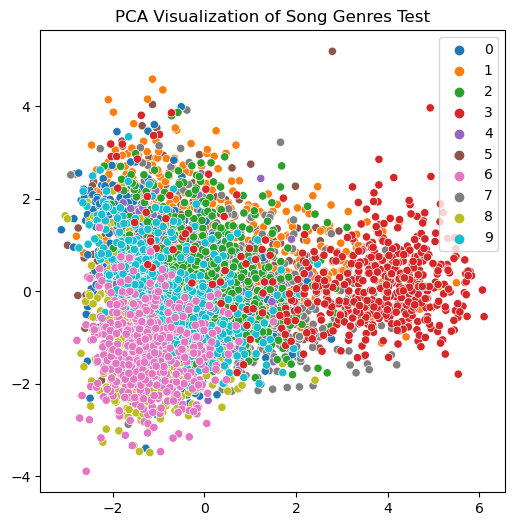

In [32]:
pca = PCA(n_components=2, random_state=13072967)
pca.fit(X_test)
T_pca= pca.transform(X_test)

# Define a color map with a distinct color for each label
cmap = plt.get_cmap('tab10')

# Get a list of all the unique labels in the training set
labels = np.unique(y_test)

# Define a dictionary that maps each label to a distinct color
palette = {label: cmap(i) for i, label in enumerate(labels)}

# Plot the PCA reduced data with colored points for each label
plt.figure(figsize=(6,6))
sns.scatterplot(x=T_pca[:, 0], y=T_pca[:, 1], hue=y_test, palette=palette)
plt.title('PCA Visualization of Song Genres Test')
plt.show()

In [9]:
# Perform t-SNE to further reduce the dimensionality of the song data to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=13072967, n_jobs=-1)
X_tsne = tsne.fit_transform(X_train)

In [33]:
Xs=X_tsne

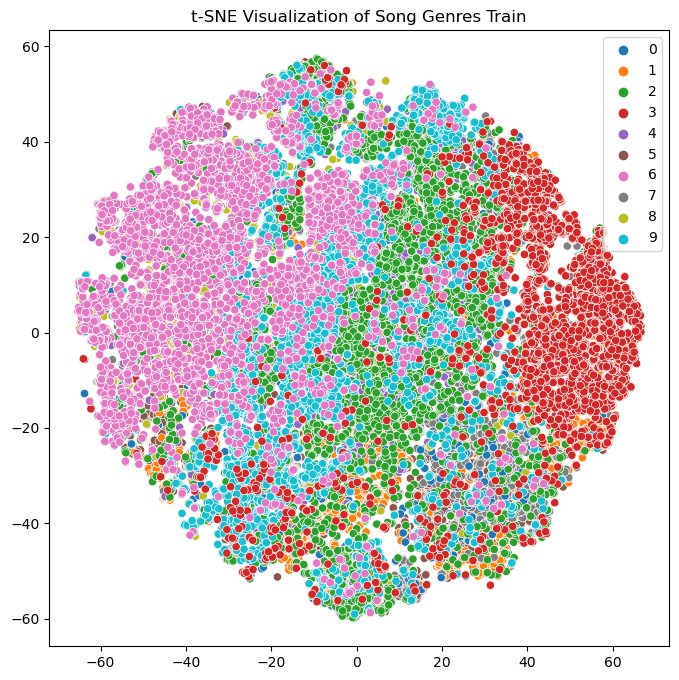

In [34]:
# Define a color map with a distinct color for each label
cmap = plt.get_cmap('tab10')

# Get a list of all the unique labels in the training set
labels = np.unique(y_train)

# Define a dictionary that maps each label to a distinct color
palette = {label: cmap(i) for i, label in enumerate(labels)}

# Plot the t-SNE reduced data with colored points for each label
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette=palette)
plt.title('t-SNE Visualization of Song Genres Train')
plt.show()

In [12]:
# Perform t-SNE to further reduce the dimensionality of the song data to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=13072967)
T_tsne = tsne.fit_transform(X_test)

In [13]:
Ts=T_tsne

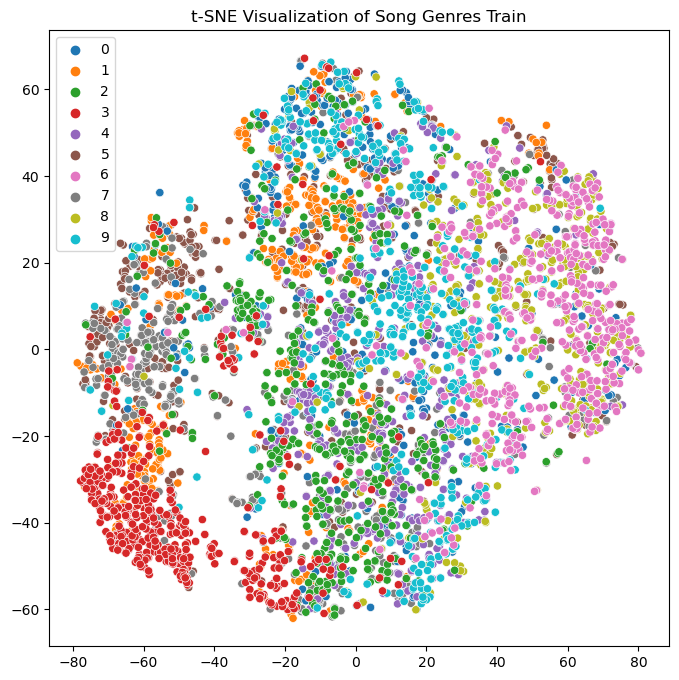

In [14]:
# Define a color map with a distinct color for each label
cmap = plt.get_cmap('tab10')

# Get a list of all the unique labels in the training set
labels = np.unique(y_test)

# Define a dictionary that maps each label to a distinct color
palette = {label: cmap(i) for i, label in enumerate(labels)}

# Plot the t-SNE reduced data with colored points for each label
plt.figure(figsize=(8,8))
sns.scatterplot(x=T_tsne[:, 0], y=T_tsne[:, 1], hue=y_test, palette=palette)
plt.title('t-SNE Visualization of Song Genres Train')
plt.show()

Clustering

In [51]:
pca_scores = []
for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=13072967)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    pca_scores.append((k, score, labels))

# Print the best number of clusters and corresponding silhouette scores for PCA and t-SNE
best_pca = max(pca_scores, key=lambda x: x[1])
print("Best number of clusters and silhouette score for PCA:", best_pca[0], best_pca[1])


Best number of clusters and silhouette score for PCA: 4 0.39928596018598644


In [52]:
tsne_scores = []
for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=13072967)
    labels = kmeans.fit_predict(X_tsne)
    score = silhouette_score(X_tsne, labels)
    tsne_scores.append((k, score, labels))
best_tsne = max(tsne_scores, key=lambda x: x[1])
print("Best number of clusters and silhouette score for t-SNE:", best_tsne[0], best_tsne[1])

Best number of clusters and silhouette score for t-SNE: 7 0.3815825


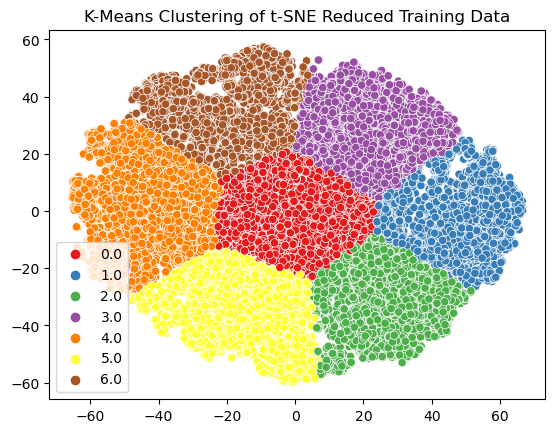

In [10]:
kmeans = KMeans(n_clusters=7, random_state=13072967)
kmeans.fit(X_tsne)
labels_tsne = kmeans.labels_
X_tsne = np.concatenate([X_tsne, np.expand_dims(labels_tsne, axis=1)], axis=1)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X_tsne[:, 2], palette='Set1')
plt.title('K-Means Clustering of t-SNE Reduced Training Data')
plt.show()

In [15]:
kmeans.fit(T_tsne)

Tlabels_tsne = kmeans.labels_
T_tsne = np.concatenate([T_tsne, np.expand_dims(Tlabels_tsne, axis=1)], axis=1)

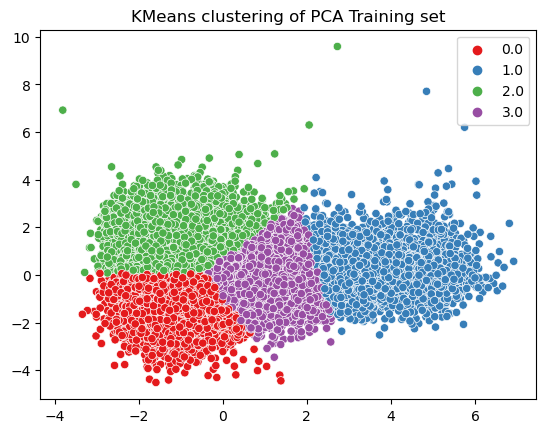

In [36]:
kmeans = KMeans(n_clusters= 4, random_state=13072967)
kmeans.fit(X_pca)
labels_pca = kmeans.labels_

X_pca= np.concatenate([X_pca, np.expand_dims(labels_pca, axis=1)], axis=1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_pca[:, 2], palette='Set1')

plt.title('KMeans clustering of PCA Training set')
plt.show()


kmeans = KMeans(n_clusters=4, random_state=13072967)
kmeans.fit(T_pca)
Tlabels_pca = kmeans.labels_
T_pca= np.concatenate([T_pca, np.expand_dims(Tlabels_pca, axis=1)], axis=1)

In [50]:
X_train['label']=X_pca[:,2]
X_test['label']=T_pca[:,2]

Classificaiton Model

In [51]:
# Define the models
rf = RandomForestClassifier(random_state=13072967)
nn = MLPClassifier(max_iter=3000, random_state=13072967)
ab = AdaBoostClassifier(random_state=13072967)

# Define the parameter grids for each model
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

nn_param_grid = {
    'hidden_layer_sizes': [(30,22,15), (35, 25, 10),(40,25,15)],
    'activation': ['relu', 'logistic']
}

ab_param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.5]
}
from sklearn.model_selection import GridSearchCV
# Perform grid search for each model
for model, param_grid in zip([rf, nn, ab], [rf_param_grid, nn_param_grid, ab_param_grid]):
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    # Print the best parameters and score
    print(f"{type(model).__name__} - Best Parameters: {grid_search.best_params_}")
    
    # Evaluate the model with the best parameters on the test set
    model = grid_search.best_estimator_
    y_pred_proba = model.predict_proba(X_test)
       # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test_binarized.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc=roc_auc["micro"]
    pred=model.predict(X_test)
    acc=(y_test == pred).sum() / len(y_test)
    print(f"{type(model).__name__} - ROC AUC score: {roc_auc:.2f}-Accuracy: {acc:.2f}")



RandomForestClassifier - Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
RandomForestClassifier - ROC AUC score: 0.92-Accuracy: 0.55
MLPClassifier - Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (40, 25, 15)}
MLPClassifier - ROC AUC score: 0.94-Accuracy: 0.59
AdaBoostClassifier - Best Parameters: {'learning_rate': 0.5, 'n_estimators': 100}
AdaBoostClassifier - ROC AUC score: 0.87-Accuracy: 0.52


In [47]:
svm = LinearSVC(random_state=13072067)
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Print the micro-average ROC AUC score
print("SVM ROC AUC score:", roc_auc["micro"])


SVM ROC AUC score: 0.8769440755555555


In [15]:
pred=model.predict(X_test)
acc=(y_test == pred).sum() / len(y_test)
# Print the micro-average ROC AUC score
print("SVM accuracy score:", acc)

SVM accuracy score: 0.514


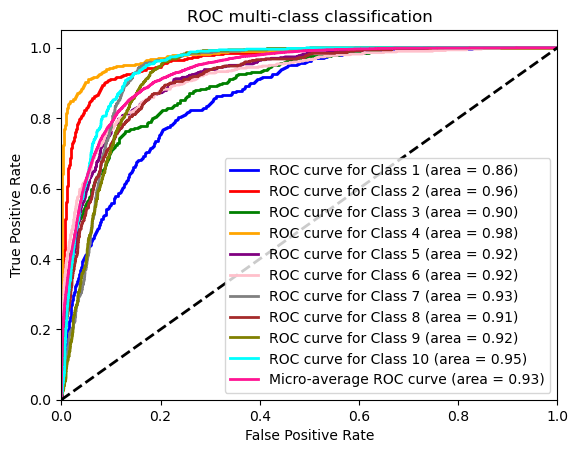

In [56]:

# Set up the classifier with the best parameters
nn= MLPClassifier(activation='logistic', hidden_layer_sizes=(40, 25, 15), random_state=13072967)

# Train the classifier on your training data
nn.fit(X_train, y_train)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and micro-average ROC curve
plt.figure()
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink', 'gray', 'brown', 'olive', 'cyan']
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10']
for i, color, label in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve for ' + label + ' (area = %0.2f)' % roc_auc[i])
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw,
         label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC multi-class classification')
plt.legend(loc="lower right")
plt.show()

Extra Credit


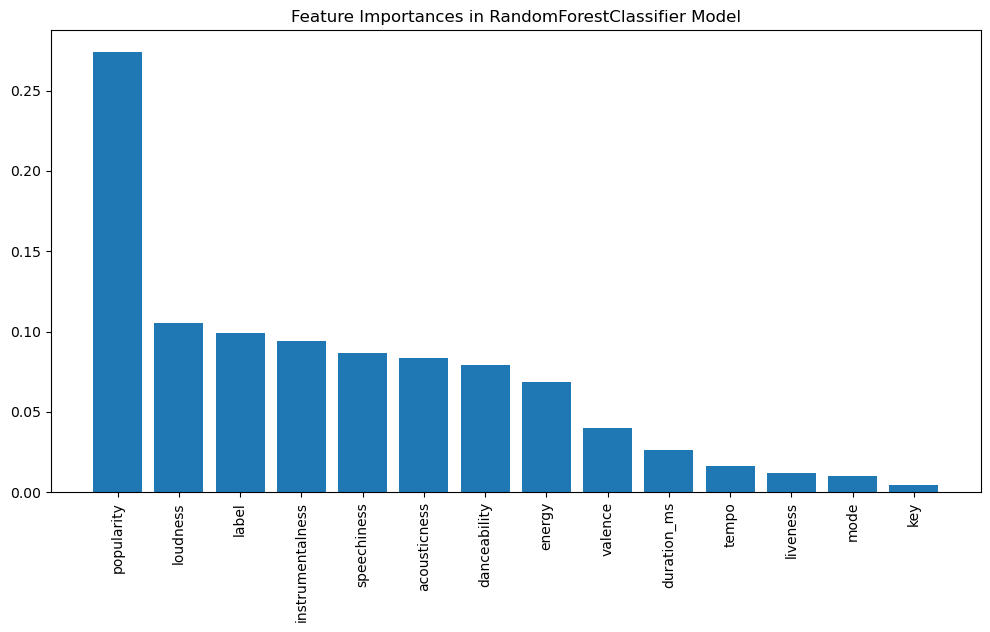

In [22]:
# Extract the feature importances
importances = rf.feature_importances_
feature_names = list(X_train.columns)

# Plot the feature importances in descending order
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances in RandomForestClassifier Model")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()

In [48]:
group_0 = X_train[X_train['label'] == 0]
group_1 = X_train[X_train['label'] == 1]
group_2 = X_train[X_train['label'] == 2]
group_3 = X_train[X_train['label'] == 3]


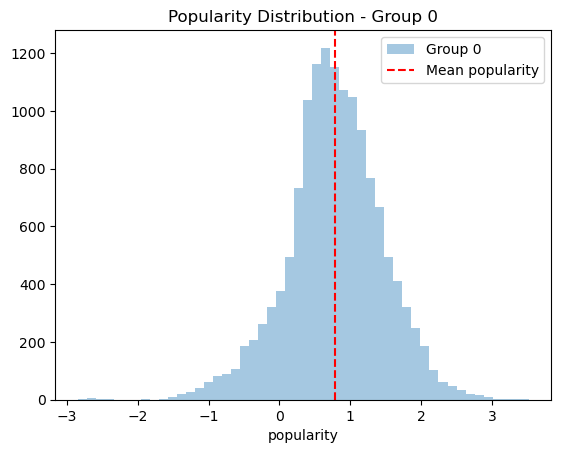

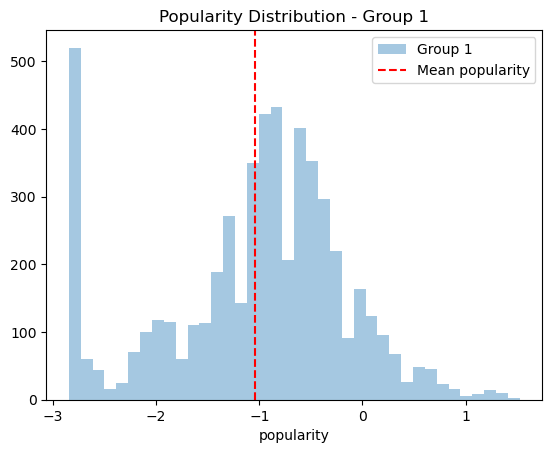

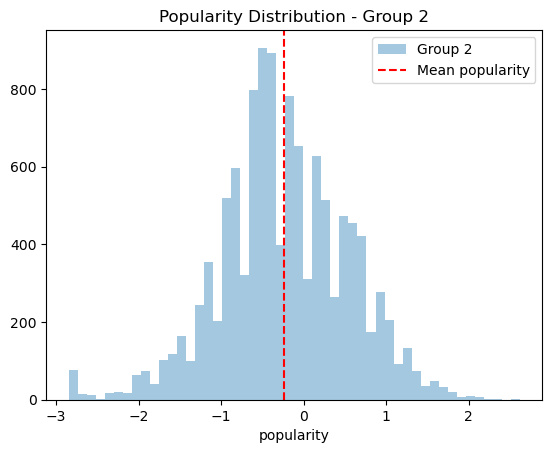

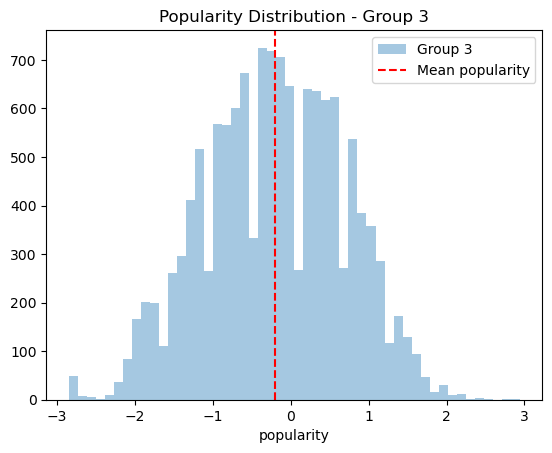

In [49]:
groups = [group_0, group_1, group_2, group_3]
for i, group in enumerate(groups):
    popularity = group['popularity']
    mean_popularity = popularity.mean()
    sns.distplot(popularity, kde=False, label='Group {}'.format(i))
    plt.axvline(mean_popularity, color='r', linestyle='--', label='Mean popularity')
    plt.title('Popularity Distribution - Group {}'.format(i))
    plt.legend()
    plt.show()

In [51]:
from scipy.stats import f_oneway

groups = [group_0, group_1, group_2, group_3]
popularity_groups = [group['popularity'] for group in groups]

f_statistic, p_value = f_oneway(*popularity_groups)

print('ANOVA F-statistic:', f_statistic)
print('p-value:', p_value)

ANOVA F-statistic: 8122.970308100804
p-value: 0.0
